In [53]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
import os
from glob import glob

# --- Parámetros generales ---
FS = 50             # Frecuencia muestreo acelerómetro (Hz)
FPS = 25            # Frecuencia anotaciones (video)
SEGMENT_START = 0   # Segundo inicial del segmento vid2_seg7
WINDOW_SIZE = 100   # 2 segundos
STEP_SIZE = 50      # 50% solapamiento
COLS = ['accelX', 'accelY', 'accelZ']

# --- Cargar anotaciones ---
#ann = pd.read_csv('/Volumes/staff-bulk/ewi/insy/SPCDataSets/conflab-mm/v4/release/annotations/actions/laughing/Only_Audio/vid2_seg7_ann1.csv')


ANNOTATION_BASE = '/Volumes/staff-bulk/ewi/insy/SPCDataSets/conflab-mm/v4/release/annotations/actions/laughing'
SOURCE_TYPES = ['No_Audio', 'Only_Audio', 'With_Audio']

annotation_files = []

for src_type in SOURCE_TYPES:
    folder = os.path.join(ANNOTATION_BASE, src_type)
    files = sorted(glob(os.path.join(folder, '*.csv')))
    for f in files:
        annotation_files.append({
            "source": src_type,
            "path": f,
            "filename": os.path.basename(f),
            "video_id": os.path.basename(f).split('_')[0],
            "segment": os.path.basename(f).split('_')[1],
            "annotator": os.path.basename(f).split('_')[2].replace('.csv', '')
        })


In [54]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low, high = lowcut / nyq, highcut / nyq
    return butter(order, [low, high], btype='band')
#Esto sirve para bloquear freq debajo o por ensima de los parametros

def apply_filter(signal, lowcut=0.5, highcut=10.0, fs=50):
    b, a = butter_bandpass(lowcut, highcut, fs)
    return filtfilt(b, a, signal)

In [61]:
def load_annotations_majority_vote(annotation_files, verbose=True):
    from collections import defaultdict

    grouped = defaultdict(list)
    for ann in annotation_files:
        key = (ann['video_id'], ann['segment'])
        grouped[key].append(ann['path'])

    annotations_by_segment = {}
    total_raw_ones = 0
    total_raw_zeros = 0
    total_majority_ones = 0
    total_majority_zeros = 0
    total_majority_frames = 0
    total_segments = 0
    segments_skipped = 0

    for (video_id, segment), paths in grouped.items():
        dfs = []
        for path in paths:
            try:
                df = pd.read_csv(path, encoding='latin1', on_bad_lines='skip')
                dfs.append(df)
            except Exception as e:
                if verbose:
                    print(f"❌ Error cargando {path}: {e}")
                continue

        if len(dfs) < 2:
            if verbose:
                print(f"⚠️ Segmento {video_id}_{segment} tiene menos de 2 anotaciones válidas. Saltado.")
            segments_skipped += 1
            continue

        # Columnas comunes (participantes)
        common_cols = set(dfs[0].columns)
        for df in dfs[1:]:
            common_cols = common_cols.intersection(set(df.columns))
        if not common_cols:
            if verbose:
                print(f"⚠️ No hay columnas comunes entre anotadores para {video_id}_{segment}. Saltado.")
            segments_skipped += 1
            continue

        common_cols = sorted(common_cols, key=lambda x: int(x))
        min_len = min(len(df) for df in dfs)
        dfs = [df.loc[:min_len-1, common_cols] for df in dfs]

        # Conteo bruto (antes de votar), ignorando NaN
        for df in dfs:
            raw_ones = int(np.nansum(df.values))
            raw_total = np.count_nonzero(~np.isnan(df.values))
            total_raw_ones += raw_ones
            total_raw_zeros += raw_total - raw_ones


        # Voto por mayoría
        stacked = np.stack([df.values for df in dfs], axis=0)  # (n, frames, participants)
        majority = (np.sum(stacked, axis=0) >= (len(dfs) // 2 + 1)).astype(int)

        annotations_by_segment[(video_id, segment)] = pd.DataFrame(
            majority, columns=[f'p{col}' for col in common_cols]
        )

        total_majority_ones += int(np.sum(majority))
        total_majority_frames += majority.size

        total_segments += 1

    total_majority_zeros = total_majority_frames - total_majority_ones

    if verbose:
        print("\n📊 Estadísticas de anotaciones:")
        print(f"🔢 Total de archivos CSV cargados: {len(annotation_files)}")
        print(f"👥 Anotadores únicos detectados: {len(set([f['annotator'] for f in annotation_files]))}")
        print(f"📁 Segmentos totales encontrados: {len(grouped)}")
        print(f"✅ Segmentos procesados con éxito: {total_segments}")
        print(f"⛔ Segmentos descartados: {segments_skipped}")
        print("\n📉 Etiquetas antes de la votación (raw):")
        print(f"   😂 Total de '1' (risa): {total_raw_ones}")
        print(f"   😐 Total de '0' (no risa): {total_raw_zeros}")
        print("\n✅ Etiquetas después de la votación por mayoría:")
        print(f"   😂 Total de '1' (risa): {total_majority_ones}")
        print(f"   😐 Total de '0' (no risa): {total_majority_zeros}")

    return annotations_by_segment


In [62]:
# --- Ejecutar carga de anotaciones ---
annotations_by_segment = load_annotations_majority_vote(annotation_files)



📊 Estadísticas de anotaciones:
🔢 Total de archivos CSV cargados: 207
👥 Anotadores únicos detectados: 3
📁 Segmentos totales encontrados: 23
✅ Segmentos procesados con éxito: 23
⛔ Segmentos descartados: 0

📉 Etiquetas antes de la votación (raw):
   😂 Total de '1' (risa): 1126696
   😐 Total de '0' (no risa): 51453284

✅ Etiquetas después de la votación por mayoría:
   😂 Total de '1' (risa): 17519
   😐 Total de '0' (no risa): 5824714


In [63]:
def segment_signal(df, window_size, step_size, columns):
    segments, starts = [], []
    for start in range(0, len(df) - window_size + 1, step_size):
        end = start + window_size
        segments.append(df[columns].iloc[start:end].values)
        starts.append(df['time'].iloc[start])
    return np.array(segments), np.array(starts)
#Divide la señal completa en segmentos de tamaños especiifos

In [64]:
import numpy as np

def extract_features(segment):
    # segment shape: (window_size, 3) — for accelX_filt, accelY_filt, accelZ_filt
    x, y, z = segment[:, 0], segment[:, 1], segment[:, 2]

    features = []

    # Por eje (mean, std, max, min, energy)
    for axis_data in [x, y, z]:
        features.extend([
            np.mean(axis_data),
            np.std(axis_data),
            np.max(axis_data),
            np.min(axis_data),
            np.sum(axis_data ** 2),  # Energy
        ])

    # Signal Magnitude Area (SMA)
    sma = np.mean(np.abs(x) + np.abs(y) + np.abs(z))
    features.append(sma)

    # Correlación entre ejes (X-Y, X-Z, Y-Z)
    features.append(np.corrcoef(x, y)[0, 1])
    features.append(np.corrcoef(x, z)[0, 1])
    features.append(np.corrcoef(y, z)[0, 1])

    return features


In [65]:
# --- Cargar señales de acelerómetro UNA SOLA VEZ por participante ---
df_dict = {}

for pid in range(1, 51):
    try:
        df = pd.read_csv(
            f'/Volumes/staff-bulk/ewi/insy/SPCDataSets/conflab-mm/release/sensors/processed/{pid}.csv',
            usecols=COLS,
            encoding='latin1',
            on_bad_lines='skip'
        )

        # Asegurarse que los datos sean numéricos
        for col in COLS:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        # Eliminar filas con NaNs
        df.dropna(subset=COLS, inplace=True)

        # Generar columna de tiempo
        df['time'] = np.arange(len(df)) / FS

        # Aplicar filtro Butterworth a cada eje
        for axis in COLS:
            df[f'{axis}_filt'] = apply_filter(df[axis])

        # Normalizar los ejes filtrados
        scaler = StandardScaler()
        df[[f'{c}_filt' for c in COLS]] = scaler.fit_transform(df[[f'{c}_filt' for c in COLS]])

        # Guardar en el diccionario
        df_dict[pid] = df
        print(f"✅ Señal cargada para participante {pid}")

    except Exception as e:
        print(f"❌ Error cargando señal de participante {pid}: {e}")


✅ Señal cargada para participante 1
✅ Señal cargada para participante 2
✅ Señal cargada para participante 3
✅ Señal cargada para participante 4
✅ Señal cargada para participante 5
✅ Señal cargada para participante 6
✅ Señal cargada para participante 7
✅ Señal cargada para participante 8
✅ Señal cargada para participante 9
✅ Señal cargada para participante 10
✅ Señal cargada para participante 11
✅ Señal cargada para participante 12
✅ Señal cargada para participante 13
✅ Señal cargada para participante 14
✅ Señal cargada para participante 15
✅ Señal cargada para participante 16
✅ Señal cargada para participante 17
✅ Señal cargada para participante 18
✅ Señal cargada para participante 19
✅ Señal cargada para participante 20
✅ Señal cargada para participante 21
✅ Señal cargada para participante 22
✅ Señal cargada para participante 23
✅ Señal cargada para participante 24
✅ Señal cargada para participante 25
✅ Señal cargada para participante 26
✅ Señal cargada para participante 27
✅ Señal ca

In [66]:
def construir_dataset(annotations_by_segment, df_dict, video_segments, FS=50, FPS=25, WINDOW_SIZE=100, STEP_SIZE=50, COLS=['accelX', 'accelY', 'accelZ']):
    X_total = []
    y_total = []
    resumen_data = []

    for (video_id, segment_id), ann_df in annotations_by_segment.items():
        segment_key = f"{video_id}_{segment_id}"

        if segment_key not in video_segments:
            print(f"⚠️ Segmento {segment_key} no tiene tiempos definidos. Saltado.")
            continue

        start_t, end_t = video_segments[segment_key]
        duration_sec = end_t - start_t
        duration_frames = int(duration_sec * FS)

        for col in ann_df.columns:
            pid = int(col[1:])  # de 'p17' → 17
            if pid not in df_dict:
                print(f"⚠️ Participante {pid} no tiene señal cargada. Saltado.")
                continue

            df_full = df_dict[pid]
            df = df_full[(df_full['time'] >= start_t) & (df_full['time'] < end_t)].copy()
            if df.empty:
                continue

            # Sliding window
            segments, starts = segment_signal(df, WINDOW_SIZE, STEP_SIZE, [f'{c}_filt' for c in COLS])
            if len(segments) == 0:
                continue

            features = [extract_features(seg) for seg in segments]
            centers = starts + (WINDOW_SIZE / (2 * FS))

            # Interpolar etiquetas
            label_vector = ann_df[col].values.astype(float)
            label_times = np.arange(len(label_vector)) / FPS
            valid_idx = (centers >= label_times[0]) & (centers <= label_times[-1])
            if valid_idx.sum() == 0:
                continue

            valid_centers = centers[valid_idx]
            valid_features = [features[i] for i in range(len(features)) if valid_idx[i]]
            labels_interp = np.interp(valid_centers, label_times, label_vector)
            labels = [int(round(x)) for x in labels_interp if not np.isnan(x)]

            # Guardar
            X_total.extend(valid_features)
            y_total.extend(labels)

            resumen_data.append({
                "video": segment_key,
                "pid": pid,
                "n_segmentos": len(valid_features),
                "n_risa": sum(labels)
            })

    return X_total, y_total, resumen_data


In [67]:
X_total, y_total, resumen_data = construir_dataset(
    annotations_by_segment,
    df_dict,
    video_segments,
    FS=50,
    FPS=25,
    WINDOW_SIZE=100,
    STEP_SIZE=50
)

In [70]:
print(f"Total de ventanas: {len(X_total)}")
print(f"Total risas: {sum(y_total)}, Total no risas: {len(y_total) - sum(y_total)}")

df_resumen = pd.DataFrame(resumen_data)
display(df_resumen.head())


Total de ventanas: 5355
Total risas: 26, Total no risas: 5329


,video,pid,n_segmentos,n_risa
0,vid2_seg7,1,119,0
1,vid2_seg7,4,119,0
2,vid2_seg7,5,119,0
3,vid2_seg7,6,119,0
4,vid2_seg7,7,119,0


In [75]:
import pandas as pd
import matplotlib.pyplot as plt

def analizar_resumen_risa(resumen_data, output_csv="resumen_risa.csv"):
    # Convertir a DataFrame
    df_resumen = pd.DataFrame(resumen_data)

    if df_resumen.empty:
        print("⚠️ El resumen está vacío. Nada que analizar.")
        return

    # Calcular % de risa
    df_resumen["porcentaje_risa"] = df_resumen["n_risa"] / df_resumen["n_segmentos"]

    # Guardar CSV
    df_resumen.to_csv(output_csv, index=False)
    print(f"✅ Resumen guardado como {output_csv}")

    # Buscar repeticiones de combinaciones video-participante
    conteo = df_resumen.groupby(["video", "pid"]).size().reset_index(name="n_repeticiones")
    conteo_duplicados = conteo[conteo["n_repeticiones"] > 1]

    if not conteo_duplicados.empty:
        print("\n🔁 Combinaciones repetidas (video, pid):")
        print(conteo_duplicados)
    else:
        print("\n✅ No hay combinaciones repetidas (video, pid).")

    # Mostrar top 10 videos con más etiquetas de risa
    print("\n🏆 Top 10 videos con más etiquetas de risa:")
    print(df_resumen.groupby("video")["n_risa"].sum().sort_values(ascending=False).head(10))

    # Eliminar duplicados para graficar (si algún (video, pid) aparece más de una vez)
    df_resumen_clean = df_resumen.drop_duplicates(subset=["video", "pid"])

    # Graficar distribución del % de risa
    plt.figure(figsize=(7, 4))
    df_resumen_clean["porcentaje_risa"].hist(bins=30)
    plt.title("Distribution of Laughter Percentage per Participant-Video")
    plt.xlabel("Laughter Percentage (%)")
    plt.ylabel("Number of Participant-Video Combinations")
    plt.tight_layout()
    plt.show()


✅ Resumen guardado como resumen_risa.csv

✅ No hay combinaciones repetidas (video, pid).

🏆 Top 10 videos con más etiquetas de risa:
video
vid2_seg8    25
vid2_seg7     1
Name: n_risa, dtype: int64


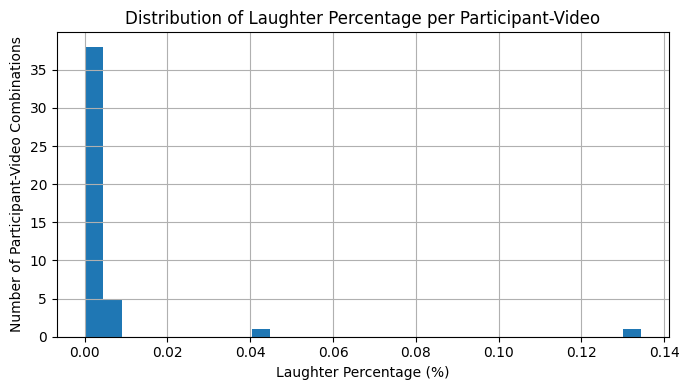

In [76]:
analizar_resumen_risa(resumen_data)


In [79]:
segmentos_mas_risa = df_resumen.groupby("video")["n_risa"].sum().reset_index()
segmentos_mas_risa = segmentos_mas_risa.sort_values("n_risa", ascending=False)
print(segmentos_mas_risa.head(10))  # Top 10 segmentos con más risas


       video  n_risa
1  vid2_seg8      25
0  vid2_seg7       1


In [85]:
from collections import Counter

# Analizar etiquetas de un segmento específico
ann_df = annotations_by_segment[('vid2', 'seg8')]
print("Distribución de etiquetas para cada participante en vid2_seg8:")
for col in ann_df.columns:
    c = Counter(ann_df[col])
    print(f"{col}: {dict(c)}")


Distribución de etiquetas para cada participante en vid2_seg8:
p1: {0: 6786, 1: 414}
p3: {0: 7200}
p4: {0: 7200}
p5: {0: 7200}
p6: {0: 7200}
p7: {0: 7200}
p9: {0: 7200}
p10: {0: 7200}
p11: {0: 7200}
p12: {0: 7200}
p15: {0: 7181, 1: 19}
p16: {0: 7074, 1: 126}
p18: {0: 7200}
p20: {0: 7200}
p21: {0: 7200}
p22: {0: 7193, 1: 7}
p23: {0: 7200}
p24: {0: 7186, 1: 14}
p25: {0: 6995, 1: 205}
p26: {0: 7200}
p27: {0: 7200}
p28: {0: 7168, 1: 32}
p29: {0: 7200}
p30: {0: 7191, 1: 9}
p31: {0: 7200}
p32: {0: 7159, 1: 41}
p33: {0: 7089, 1: 111}
p35: {0: 7185, 1: 15}


In [ ]:
#Random Forest Classifier

Classification Report:
              precision    recall  f1-score   support

 No Laughter       1.00      1.00      1.00      1066
    Laughter       0.00      0.00      0.00         5

    accuracy                           1.00      1071
   macro avg       0.50      0.50      0.50      1071
weighted avg       0.99      1.00      0.99      1071



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

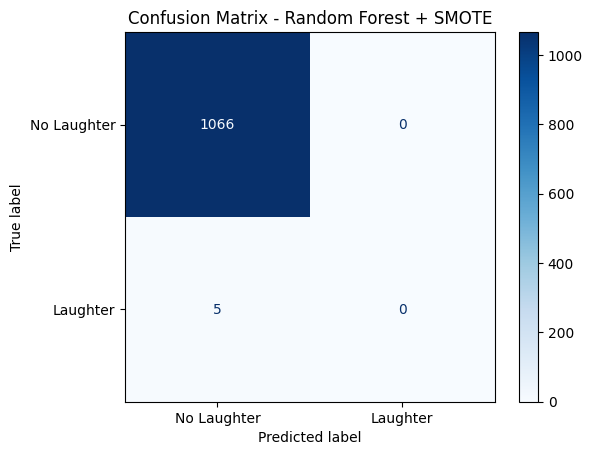

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# 1. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_total, y_total, test_size=0.2, stratify=y_total, random_state=42
)

# 2. Train classifier (without SMOTE)
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# 4. Predict and evaluate
y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["No Laughter", "Laughter"]))

# 5. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Laughter", "Laughter"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Random Forest + SMOTE")
plt.show()


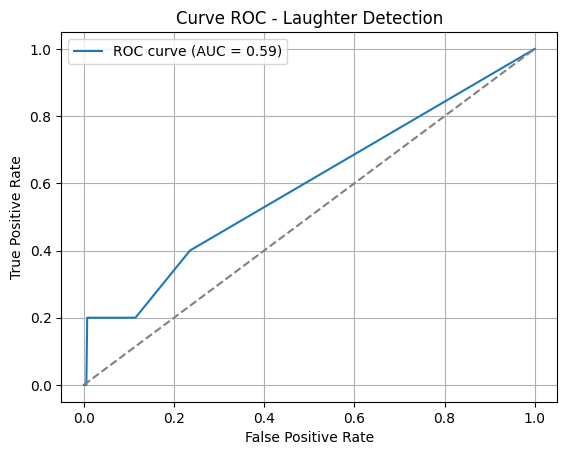

In [81]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obtener probabilidades de clase
y_probs = clf.predict_proba(X_test)[:, 1]

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curve ROC - Laughter Detection')
plt.legend()
plt.grid()
plt.show()


In [82]:
import numpy as np
from sklearn.metrics import precision_recall_curve

# Curva precision-recall
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Buscar el umbral con mejor F1-score
f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]

print(f"Mejor umbral por F1-score: {best_thresh:.2f}")
print(f"Precision: {precision[best_idx]:.2f}, Recall: {recall[best_idx]:.2f}, F1: {f1_scores[best_idx]:.2f}")

# Aplicar el nuevo umbral
y_pred_adjusted = (y_probs >= best_thresh).astype(int)

# Re-evaluar
print(classification_report(y_test, y_pred_adjusted, target_names=["No Risa", "Risa"]))


Mejor umbral por F1-score: 0.06
Precision: 0.11, Recall: 0.20, F1: 0.14
              precision    recall  f1-score   support

     No Risa       1.00      0.99      0.99      1066
        Risa       0.11      0.20      0.14         5

    accuracy                           0.99      1071
   macro avg       0.55      0.60      0.57      1071
weighted avg       0.99      0.99      0.99      1071



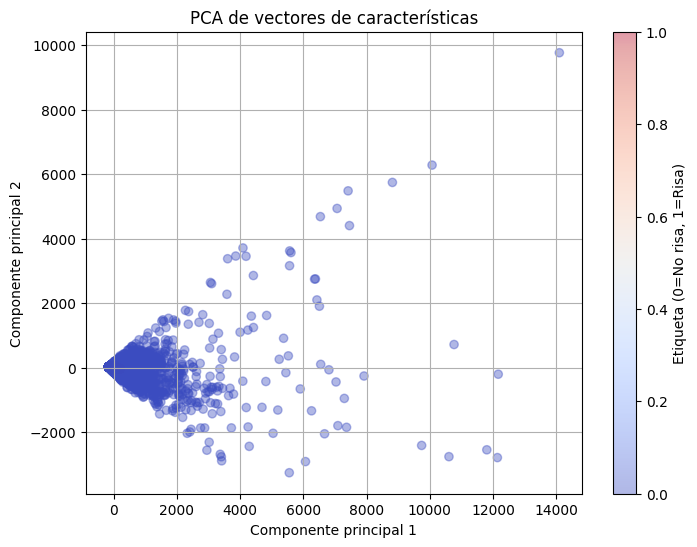

In [32]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_vis = PCA(n_components=2).fit_transform(X_total)

plt.figure(figsize=(8,6))
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_total, cmap='coolwarm', alpha=0.4)
plt.title("PCA de vectores de características")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.colorbar(label="Etiqueta (0=No risa, 1=Risa)")
plt.grid()
plt.show()


In [33]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
skf = StratifiedKFold(n_splits=5)

scores = cross_val_score(clf, X_total, y_total, scoring='f1', cv=skf)
print(f"F1-score promedio con validación cruzada: {scores.mean():.2f}")


F1-score promedio con validación cruzada: 0.00


Classification Report:
              precision    recall  f1-score   support

 No Laughter       1.00      1.00      1.00      1066
    Laughter       0.00      0.00      0.00         5

    accuracy                           0.99      1071
   macro avg       0.50      0.50      0.50      1071
weighted avg       0.99      0.99      0.99      1071



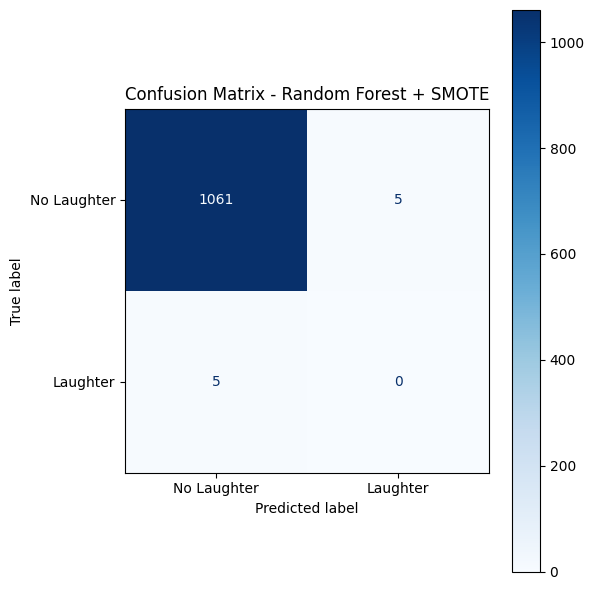

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=0.2, stratify=y_total, random_state=42)

# Apply SMOTE to balance the dataset
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# Train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_resampled, y_resampled)

# Make predictions
y_pred = clf.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["No Laughter", "Laughter"]))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Laughter", "Laughter"])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="Blues", ax=ax)
plt.title("Confusion Matrix - Random Forest + SMOTE")
plt.grid(False)
plt.tight_layout()
plt.show()


Classification Report (No SMOTE):
              precision    recall  f1-score   support

 No Laughter       1.00      1.00      1.00      1066
    Laughter       0.00      0.00      0.00         5

    accuracy                           1.00      1071
   macro avg       0.50      0.50      0.50      1071
weighted avg       0.99      1.00      0.99      1071



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

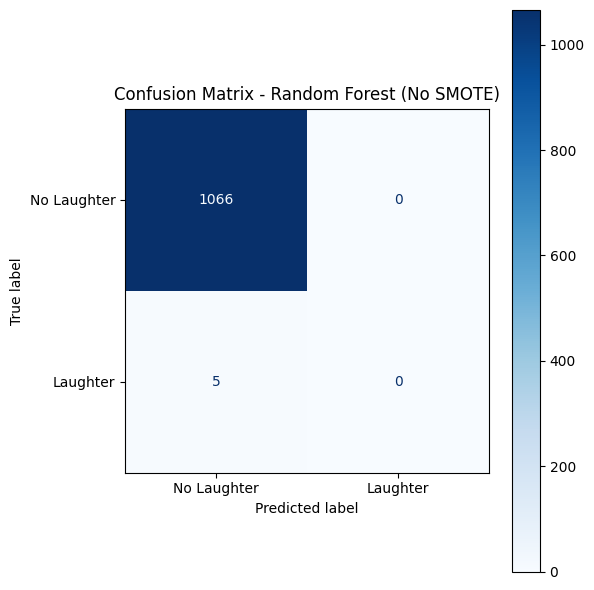

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Split the dataset (sin SMOTE)
X_train, X_test, y_train, y_test = train_test_split(
    X_total, y_total, test_size=0.2, stratify=y_total, random_state=42
)

# 2. Train the Random Forest classifier directly
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# 3. Make predictions
y_pred = clf.predict(X_test)

# 4. Print classification report
print("Classification Report (No SMOTE):")
print(classification_report(y_test, y_pred, target_names=["No Laughter", "Laughter"]))

# 5. Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Laughter", "Laughter"])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="Blues", ax=ax)
plt.title("Confusion Matrix - Random Forest (No SMOTE)")
plt.grid(False)
plt.tight_layout()
plt.show()
